a. Capture 25 paquetes de su red doméstica (no de la red de la UVG) y asígnelos a una variable.

b. Imprima el tipo de variable, la longitud y el contenido de la variable.

c. Imprima el tipo de dato del primer paquete capturado.

d. Imprima el contenido de 5 paquetes

In [ ]:
from scapy.all import sniff
#25 paquetes
paquetes = sniff(count=25)

print("Tipo de variable:", type(paquetes))

print("Cantidad de paquetes capturados:", len(paquetes))
print("Contenido de los paquetes:")
print(paquetes)

print("Tipo del primer paquete:", type(paquetes[0]))

print("Contenido de los primeros 5 paquetes:")
for i in range(5):
    print(f"\nPaquete {i+1}:")
    print(paquetes[i].summary())


Tipo de variable: <class 'scapy.plist.PacketList'>
Cantidad de paquetes capturados: 25
Contenido de los paquetes:
<Sniffed: TCP:23 UDP:2 ICMP:0 Other:0>
Tipo del primer paquete: <class 'scapy.layers.l2.Ether'>
Contenido de los primeros 5 paquetes:

Paquete 1:
Ether / IP / TCP 34.120.208.123:https > 192.168.1.36:54089 A / Padding

Paquete 2:
Ether / IP / TCP 34.120.208.123:https > 192.168.1.36:54089 PA / Raw

Paquete 3:
Ether / IP / TCP 34.120.208.123:https > 192.168.1.36:54089 PA / Raw

Paquete 4:
Ether / IP / TCP 192.168.1.36:54089 > 34.120.208.123:https A

Paquete 5:
Ether / IP / TCP 192.168.1.36:54089 > 34.120.208.123:https PA / Raw


Descargue e archivo analisis_paquetes.pcap y asignelo a una variable.

In [2]:
from scapy.all import rdpcap

# Carga el archivo pcap
paquetes = rdpcap("analisis_paquetes.pcap")


Convierta la variable a un DataFrame.

In [3]:
import pandas as pd

# Convertimos a DataFrame extrayendo datos relevantes
datos = []

for pkt in paquetes:
    if pkt.haslayer("IP"):  # Asegurarse de que tiene capa IP
        src_ip = pkt["IP"].src
        dst_ip = pkt["IP"].dst
        src_port = pkt.sport if hasattr(pkt, 'sport') else None
        dst_port = pkt.dport if hasattr(pkt, 'dport') else None
        datos.append({
            "Src Address": src_ip,
            "Dst Address": dst_ip,
            "Src Port": src_port,
            "Dst Port": dst_port
        })

df = pd.DataFrame(datos)


Muestre el contenido de las primeras 5 filas del dataset.

In [ ]:
df.head()

,Src Address,Dst Address,Src Port,Dst Port
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53


Muestre los valores de las columnas: Src Addres, Dst Address, Src Port y Dst Port.

In [ ]:
df[["Src Address", "Dst Address", "Src Port", "Dst Port"]].head()

,Src Address,Dst Address,Src Port,Dst Port
0,10.1.10.53,84.54.22.33,53,53
1,84.54.22.33,10.1.10.53,53,53
2,10.1.10.53,84.54.22.33,53,53
3,84.54.22.33,10.1.10.53,53,53
4,10.1.10.53,84.54.22.33,53,53


Mostrar todas las IP origen

In [6]:
ip_origenes = df["Src Address"].unique()
print("Todas las IP origen:")
print(ip_origenes)


Todas las IP origen:
['10.1.10.53' '84.54.22.33' '75.75.75.75']


Mostrar todas las IP destino

In [7]:
ip_destinos = df["Dst Address"].unique()
print("Todas las IP destino:")
print(ip_destinos)


Todas las IP destino:
['84.54.22.33' '10.1.10.53' '75.75.75.75']


¿Cuál es la IP origen más frecuente?

In [8]:
ip_origen_frecuente = df["Src Address"].value_counts().idxmax()
print("IP origen más frecuente:", ip_origen_frecuente)


IP origen más frecuente: 10.1.10.53


¿A qué IP destino se comunica con más frecuencia?

In [9]:
# Filtramos el DataFrame para esa IP origen
coms_frecuentes = df[df["Src Address"] == ip_origen_frecuente]

# IP destino más común desde esa IP origen
ip_destino_frecuente = coms_frecuentes["Dst Address"].value_counts().idxmax()
print("IP destino más frecuente a la que se comunica:", ip_destino_frecuente)


IP destino más frecuente a la que se comunica: 84.54.22.33


¿A qué puerto destino se comunica? ¿Cuál es el propósito de este puerto?

In [10]:
# Puerto destino más común desde esa IP origen
puerto_destino_frecuente = coms_frecuentes["Dst Port"].value_counts().idxmax()
print("Puerto destino más frecuente:", puerto_destino_frecuente)


Puerto destino más frecuente: 53


In [11]:
puertos_conocidos = {
    80: "HTTP (navegación web)",
    443: "HTTPS (navegación segura)",
    53: "DNS (resolución de nombres)",
    25: "SMTP (envío de correo)",
    22: "SSH (acceso remoto seguro)"
}

descripcion_puerto = puertos_conocidos.get(puerto_destino_frecuente, "Propósito desconocido")
print("Propósito del puerto:", descripcion_puerto)


Propósito del puerto: DNS (resolución de nombres)


¿Desde que puertos origen se comunica?

In [12]:
puertos_origen = df["Src Port"].dropna().unique()
print("Puertos origen únicos desde los que se comunica:")
print(puertos_origen)


Puertos origen únicos desde los que se comunica:
[   53 15812 23903]


Gráficas

a. Genere una gráfica de barras 2D horizontales, en el eje Y las IPs origen, y en el eje X la
suma de los payloads (bytes) enviados desde dichas direcciones.

In [13]:
from collections import defaultdict

# Diccionario para guardar la suma de payloads por IP origen
payloads_por_ip = defaultdict(int)

# Recorremos los paquetes y sumamos el tamaño de cada payload por IP origen
for pkt in paquetes:
    if pkt.haslayer("IP"):
        src_ip = pkt["IP"].src
        payload_size = len(pkt["IP"].payload)
        payloads_por_ip[src_ip] += payload_size


In [14]:
# Convertir a DataFrame para graficar fácilmente
payload_df = pd.DataFrame(list(payloads_por_ip.items()), columns=["IP Origen", "Bytes Enviados"])
# Ordenamos para que la gráfica sea más clara
payload_df = payload_df.sort_values(by="Bytes Enviados", ascending=True)


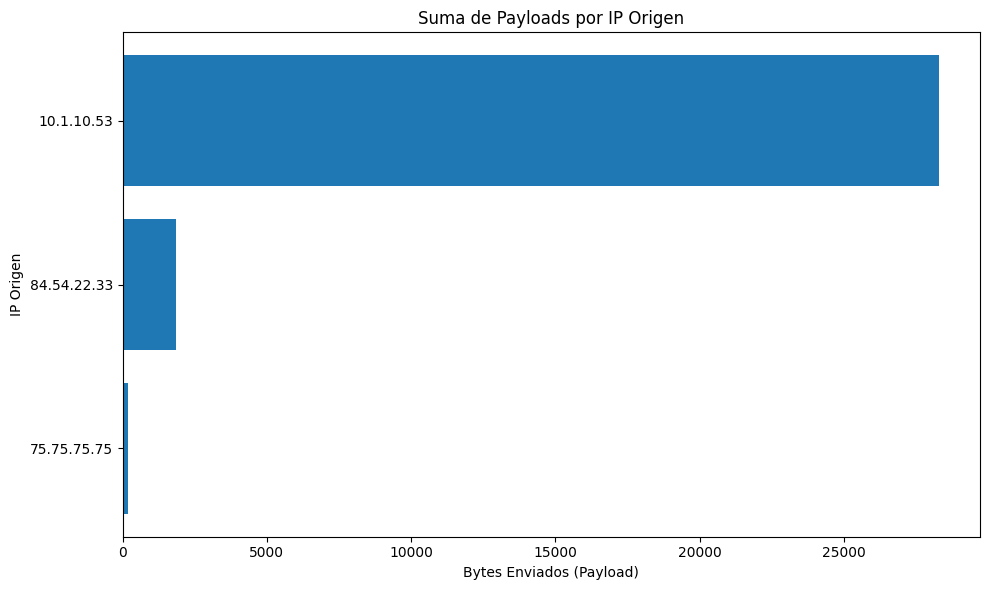

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(payload_df["IP Origen"], payload_df["Bytes Enviados"])
plt.xlabel("Bytes Enviados (Payload)")
plt.ylabel("IP Origen")
plt.title("Suma de Payloads por IP Origen")
plt.tight_layout()
plt.show()
